# Allgemeines

## Begriffe

Statistische Einheit
Grundgesamtheit
Stichprobe
Merkmal
Ausprägung

qualitativ und quantitativ
nominal ordinal diskret stetig


## Unvariante Statistik

1. Rohdatenanalyse graphisch und beschreibend
    - Scatterplot 
    - Zeitreihenanalyse (bspw. Durchschnitt über mehrere Jahre)
        - Trend, Saisonalität, Rauschen
        - gleitender Mittelwert
2. Absolute und relative Häufigkeit
    - Histogram: Wochentage oder Monatstage mit Anzahl als Histogram
    - empirische Verteilungsfunktion
3. Statistische Kennzahlen
    - Median
    - Boxplot
    - Violin-Plot

## Multivariante Statistik

1. Scatterplot auf 2 Achsen
2. Korrelation
    - Scatterplot / Heatmap
3. Lineare Regression
4. Vorhersage


In [74]:
import requests, re, os
from urllib.parse import urljoin, unquote
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import networkx as nx

# Load Data

In [75]:
herose_pattern = '.*Zaehlstelle_Heros(e|é)_[0-9]{4}_(stuendlich|taeglich)_Wetter.*.csv'
konstanz_data_portal_url = 'https://offenedaten-konstanz.de/dataset/fahrrad-dauerz-hlstellen'

req = requests.get(konstanz_data_portal_url)
soup = BeautifulSoup(req.text, "html.parser")
links = [urljoin(konstanz_data_portal_url, a["href"]) for a in soup.find_all("a", href=True) if
         a["href"].lower().endswith(".csv")]

data_dir = './data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

for link in links:
    path = f"./data/{unquote(link.rsplit("/", 1)[-1])}"

    if re.match(herose_pattern, path) and not os.path.exists(path.replace('é', 'e')):
        path = path.replace('é', 'e')

        try:
            csv_data = requests.get(link)
            print(f'Downloading to {path}')
        except requests.RequestException as e:
            print(f"failed to fetch {konstanz_data_portal_url}: {e}")
            continue

        with open(path, 'wb') as file:
            file.write(csv_data.content)
    else:
        print(f'{path} already downloaded.')

./data/Zaehlstelle_Herose_2018_stuendlich_4.csv already downloaded.
./data/Zaehlstelle_Herose_2018_stuendlich_Wetter_5.csv already downloaded.
./data/Zaehlstelle_Herose_2019_15min_2.csv already downloaded.
./data/Zaehlstelle_Herose_2019_stuendlich_Wetter_4.csv already downloaded.
./data/Zaehlstelle_Herose_2020_15min_3.csv already downloaded.
./data/Zaehlstelle_Herose_2020_stuendlich_Wetter_4.csv already downloaded.
./data/Zaehlstelle_Herose_2021_15min_3.csv already downloaded.
./data/Zaehlstelle_Herose_2021_stuendlich_Wetter_5.csv already downloaded.
./data/Zaehlstelle_Herose_2022_15min_2.csv already downloaded.
./data/Zaehlstelle_Herose_2022_stuendlich_Wetter_3.csv already downloaded.
./data/Zaehlstelle_Herosé_2023_15min.csv already downloaded.
./data/Zaehlstelle_Herosé_2023_stuendlich_Wetter.csv already downloaded.
./data/Zaehlstelle_Herosé_2023_taeglich_Wetter.csv already downloaded.
./data/Zaehlstelle_Alte_Rheinbruecke_2023_15min.csv already downloaded.
./data/Zaehlstelle_Alte_Rhei

## Load hourly Data

In [76]:
pattern = 'Zaehlstelle_Herose_[0-9]{4}_stuendlich_Wetter.*.csv'
files = [f'./data/{f}' for f in os.listdir("./data") if re.match(pattern, f)]

all_data_hourly = []
for f in files:
    time_amount_tmp = pd.read_csv(f, sep=';', engine='python')
    time_amount_tmp.columns = time_amount_tmp.columns.str.replace(r' \([^)]*\)', '', regex=True)
    all_data_hourly.append(time_amount_tmp)
all_data_hourly = pd.concat(all_data_hourly, ignore_index=True)


# postprocessing
all_data_hourly['date'] = pd.to_datetime(all_data_hourly['Zeit'], format="%d.%m.%Y %H:%M")

all_data_hourly = all_data_hourly.rename(columns={
    'Fahrradbruecke':'total_count',
    'Fahrradbruecke stadteinwaerts':'inbound_count',
    'Fahrradbruecke stadtauswaerts':'outbound_count',
    'Temperatur':'temperature',
    'Gefuehlte Temperatur':'feels_like_temperature',
    'Regen':'precipitation'
})

all_data_hourly = all_data_hourly[[
    'date',
    'total_count',
    'inbound_count',
    'outbound_count',
    'temperature',
    'feels_like_temperature',
    'precipitation'
]]

month_map = {'Jan': 1, 'Feb': 2, 'Mrz': 3, 'Apr': 4, 'Mai': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9}
regen_conv = []
for v in all_data_hourly['precipitation']:
    if isinstance(v, str) and '. ' in v:
        d, m = v.split('. ')
        regen_conv.append(float(f"{int(d)}.{month_map[m]}"))
    else:
        regen_conv.append(float(v))
all_data_hourly['precipitation'] = regen_conv

all_data_hourly

,date,total_count,inbound_count,outbound_count,temperature,feels_like_temperature,precipitation
0,2019-01-01 00:00:00,61.0,25.0,36.0,2.0,2.0,0.0
1,2019-01-01 01:00:00,100.0,49.0,51.0,2.0,2.0,0.0
2,2019-01-01 02:00:00,143.0,73.0,70.0,2.0,2.0,0.0
3,2019-01-01 03:00:00,98.0,59.0,39.0,3.0,3.0,0.0
4,2019-01-01 04:00:00,68.0,34.0,34.0,3.0,2.0,0.0
...,...,...,...,...,...,...,...
47323,2021-12-31 19:00:00,196.0,104.0,92.0,7.0,7.0,0.0
47324,2021-12-31 20:00:00,111.0,52.0,59.0,6.0,5.0,0.0
47325,2021-12-31 21:00:00,88.0,59.0,29.0,5.0,4.0,0.0
47326,2021-12-31 22:00:00,74.0,42.0,32.0,5.0,4.0,0.0


## Concat hourly data to daily

In [77]:
all_data_hourly['date'] = pd.to_datetime(all_data_hourly['date']).dt.date
all_data_daily_constructed = all_data_hourly.groupby('date').agg(
    total_count=('total_count','sum'),
    inbound_count=('inbound_count','sum'),
    outbound_count=('outbound_count','sum'),
    mean_temperature=('temperature','mean'),
    min_temperature=('temperature','min'),
    max_temperature=('temperature','max'),
    feels_like_temperature=('feels_like_temperature','mean'),
    precipitation=('precipitation','sum')
).reset_index()

all_data_daily_constructed[
    [
        'total_count',
        'inbound_count',
        'outbound_count',
        'precipitation'
    ]
] = (all_data_daily_constructed[
    [
        'total_count',
        'inbound_count',
        'outbound_count',
        'precipitation'
]].astype(int))

all_data_daily_constructed[
    [
        'mean_temperature',
        'feels_like_temperature'
    ]
] = (all_data_daily_constructed
     [
         [
             'mean_temperature',
             'feels_like_temperature'
         ]]*2).round()/2

all_data_daily_constructed.columns

Index(['date', 'total_count', 'inbound_count', 'outbound_count',
       'mean_temperature', 'min_temperature', 'max_temperature',
       'feels_like_temperature', 'precipitation'],
      dtype='object')

## Read daily 2023

In [78]:
daily_data_file = './data/Zaehlstelle_Herose_2023_taeglich_Wetter.csv'
all_data_daily = pd.read_csv(daily_data_file, sep=';', engine='python')
all_data_daily.columns = all_data_daily.columns.str.replace(r' \([^)]*\)', '', regex=True)

all_data_daily['date'] = pd.to_datetime(all_data_daily['Zeit'], format="%d.%m.%Y %H:%M").dt.date
all_data_daily = all_data_daily.drop(columns=['Zeit','Symbol Wetter','Quelle'])
all_data_daily = all_data_daily.rename(columns={
    'Fahrradbruecke':'total_count',
    'Fahrradbruecke stadteinwaerts Fahrraeder':'inbound_count',
    'Fahrradbruecke stadtauswaerts Fahrraeder':'outbound_count',
    'Temperatur':'mean_temperature',
    'Min. Temperatur':'min_temperature',
    'Max. Temperatur':'max_temperature',
    'Gefuehlte Temperatur':'feels_like_temperature',
    'Regen':'precipitation',
    'Schnee':'snow',
    'Wind':'wind',
    'Luftfeuchtigkeit':'humidity',
    'Wolken':'cloud_cover'
})
all_data_daily = all_data_daily[[
    'date',
    'total_count',
    'inbound_count',
    'outbound_count',
    'mean_temperature',
    'min_temperature',
    'max_temperature',
    'feels_like_temperature',
    'precipitation',
    'snow',
    'wind',
    'humidity',
    'cloud_cover'
]]

all_data_daily.columns

Index(['date', 'total_count', 'inbound_count', 'outbound_count',
       'mean_temperature', 'min_temperature', 'max_temperature',
       'feels_like_temperature', 'precipitation', 'snow', 'wind', 'humidity',
       'cloud_cover'],
      dtype='object')

# 1.Rohdatenanalyse
## 1.1 Plotten der Anzahl vs. Zeit

In [79]:
time_amount_tmp = all_data_daily_constructed.copy()
time_amount_tmp['dt'] = pd.to_datetime(time_amount_tmp['date'])
time_amount_tmp['month'] = time_amount_tmp['dt'].dt.month
time_amount_tmp['month_cont'] = (
        time_amount_tmp['month'] +
        (time_amount_tmp['dt'].dt.day - 1) / time_amount_tmp['dt'].dt.days_in_month
)
time_amount_tmp['year'] = time_amount_tmp['dt'].dt.year

time_amount_tmp

,date,total_count,inbound_count,outbound_count,mean_temperature,min_temperature,max_temperature,feels_like_temperature,precipitation,dt,month,month_cont,year
0,2018-08-08,8707,4195,4512,24.0,19.0,29.0,25.0,0,2018-08-08,8,8.225806,2018
1,2018-08-09,8587,4019,4568,24.0,18.0,31.0,25.5,8,2018-08-09,8,8.258065,2018
2,2018-08-10,8324,4084,4240,17.5,15.0,19.0,17.5,7,2018-08-10,8,8.290323,2018
3,2018-08-11,11913,5474,6439,18.0,13.0,24.0,18.5,0,2018-08-11,8,8.322581,2018
4,2018-08-12,7233,3353,3880,21.5,14.0,28.0,22.5,0,2018-08-12,8,8.354839,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,2023-12-27,3953,0,0,3.5,2.0,7.0,3.5,0,2023-12-27,12,12.838710,2023
1968,2023-12-28,4060,0,0,3.5,1.0,6.0,2.5,0,2023-12-28,12,12.870968,2023
1969,2023-12-29,4965,0,0,6.0,4.0,9.0,4.0,0,2023-12-29,12,12.903226,2023
1970,2023-12-30,4693,0,0,6.5,3.0,10.0,5.5,0,2023-12-30,12,12.935484,2023


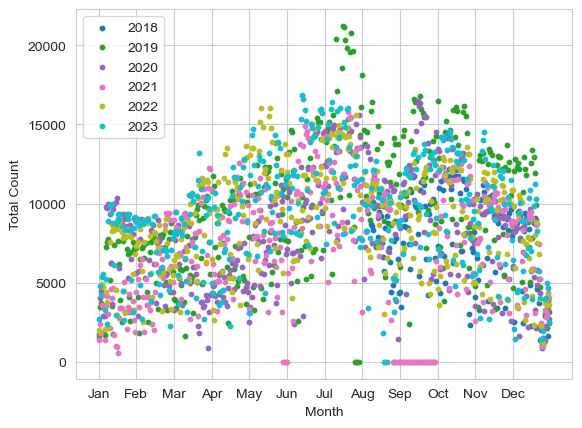

In [80]:
fig, ax = plt.subplots()

# Use the same color mapping as the first snippet
years = sorted(time_amount_tmp['year'].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(years)))

for i, y in enumerate(years):
    d = time_amount_tmp[time_amount_tmp['year'] == y]
    ax.scatter(d['month_cont'], d['total_count'], label=str(y), color=colors[i], s=10)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('Month')
ax.set_ylabel('Total Count')
ax.legend()
plt.show()

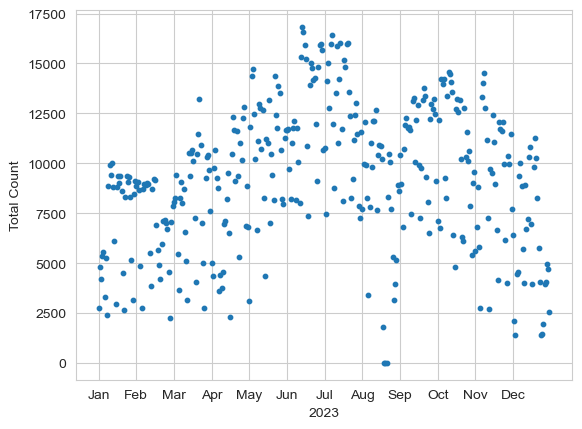

In [81]:
t2023 = time_amount_tmp[time_amount_tmp['year'] == 2023]
fig, ax = plt.subplots()
ax.scatter(t2023['month_cont'], t2023['total_count'], s=10)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('2023')
ax.set_ylabel('Total Count')
plt.show()

## 1.2 Zeitreihenanalyse

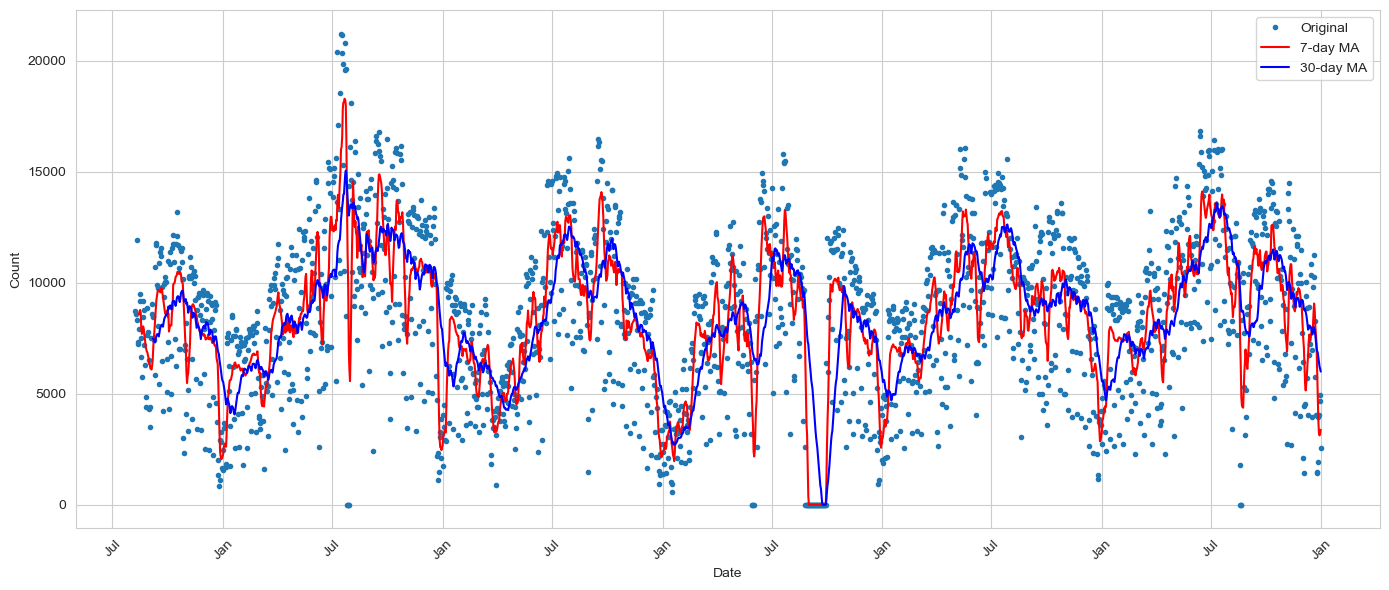

In [82]:
df = time_amount_tmp.sort_values('dt').set_index('dt')
df['ma_7'] = df['total_count'].rolling(7).mean()
df['ma_30'] = df['total_count'].rolling(30).mean()

plt.figure(figsize=(14,6))
plt.plot(df.index, df['total_count'], marker='o', linestyle='none', markersize=3, label='Original')
plt.plot(df.index, df['ma_7'], color='red', label='7-day MA')
plt.plot(df.index, df['ma_30'], color='blue', label='30-day MA')
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=10, maxticks=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

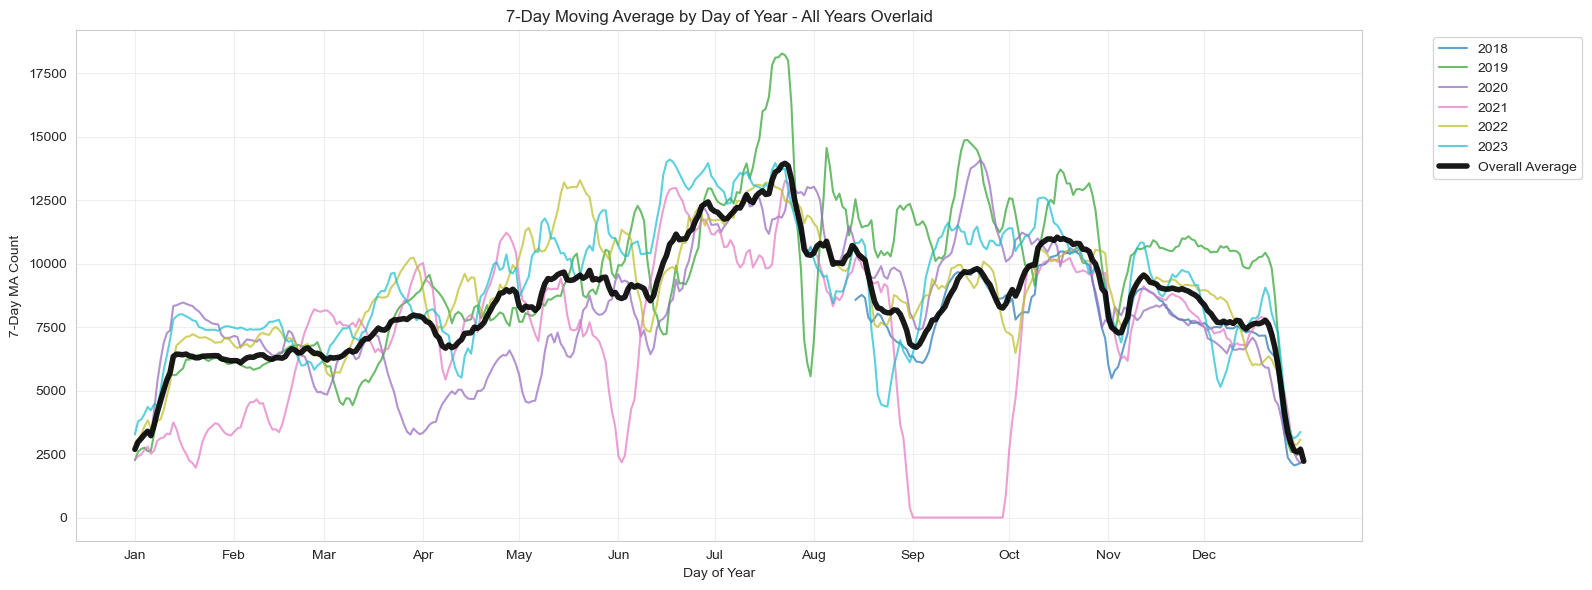

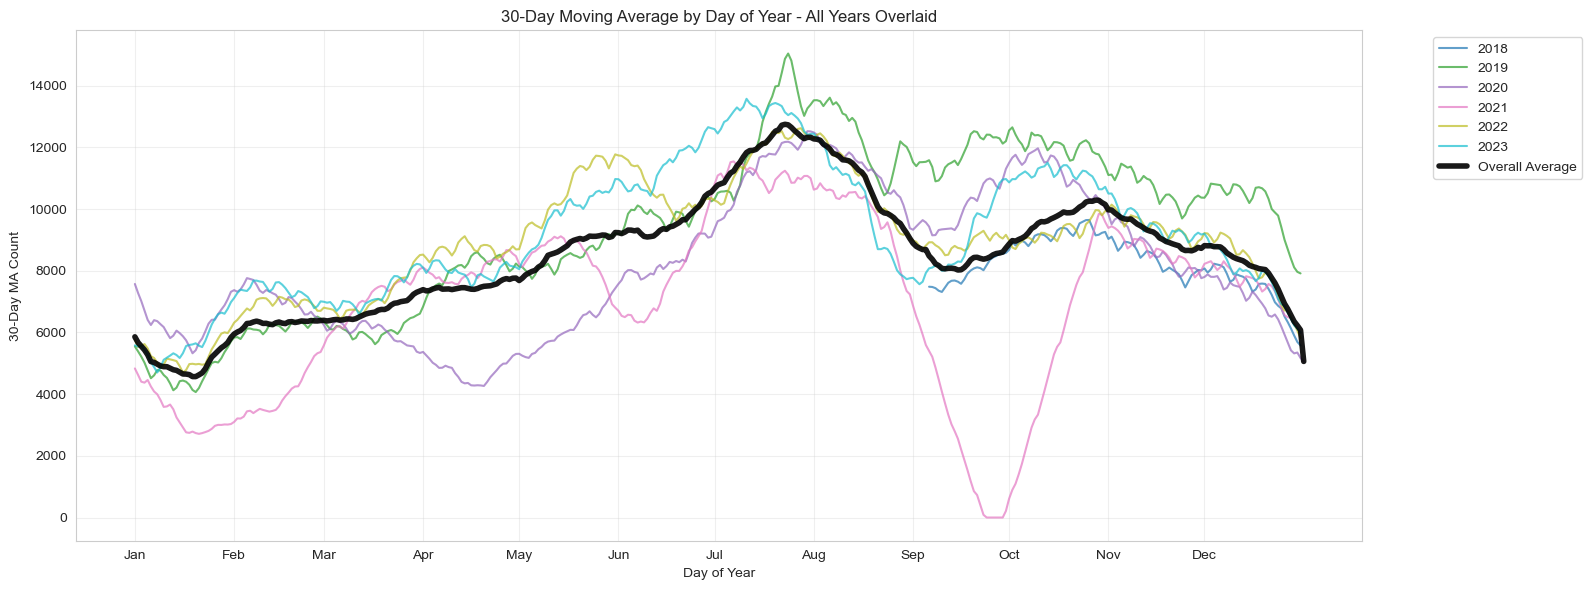

In [83]:
# Prepare the data with rolling averages
df = time_amount_tmp.sort_values('dt').set_index('dt')
df['day_of_year'] = df.index.dayofyear
df['year'] = df.index.year
df['ma_7'] = df['total_count'].rolling(7).mean()
df['ma_30'] = df['total_count'].rolling(30).mean()

# Get unique years and create a color map
years = sorted(df['year'].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(years)))

# Set x-axis months
month_starts = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# First graphic: 7-Day Moving Average
plt.figure(figsize=(16, 6))

# Plot individual years
for i, year in enumerate(years):
    year_data = df[df['year'] == year]
    plt.plot(year_data['day_of_year'], year_data['ma_7'],
             color=colors[i], linewidth=1.5, alpha=0.7, label=f'{year}')

# Calculate and plot overall 7-day MA average
overall_7day_avg = df.groupby('day_of_year')['ma_7'].mean()
plt.plot(overall_7day_avg.index, overall_7day_avg.values,
         color='black', linewidth=4, alpha=0.9, label='Overall Average')

plt.title('7-Day Moving Average by Day of Year - All Years Overlaid')
plt.xlabel('Day of Year')
plt.ylabel('7-Day MA Count')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(month_starts, month_labels)
plt.tight_layout()
plt.show()

# Second graphic: 30-Day Moving Average
plt.figure(figsize=(16, 6))

# Plot individual years
for i, year in enumerate(years):
    year_data = df[df['year'] == year]
    plt.plot(year_data['day_of_year'], year_data['ma_30'],
             color=colors[i], linewidth=1.5, alpha=0.7, label=f'{year}')

# Calculate and plot overall 30-day MA average
overall_30day_avg = df.groupby('day_of_year')['ma_30'].mean()
plt.plot(overall_30day_avg.index, overall_30day_avg.values,
         color='black', linewidth=4, alpha=0.9, label='Overall Average')

plt.title('30-Day Moving Average by Day of Year - All Years Overlaid')
plt.xlabel('Day of Year')
plt.ylabel('30-Day MA Count')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(month_starts, month_labels)
plt.tight_layout()
plt.show()

# 2. Absolute und Relative Häufigkeiten

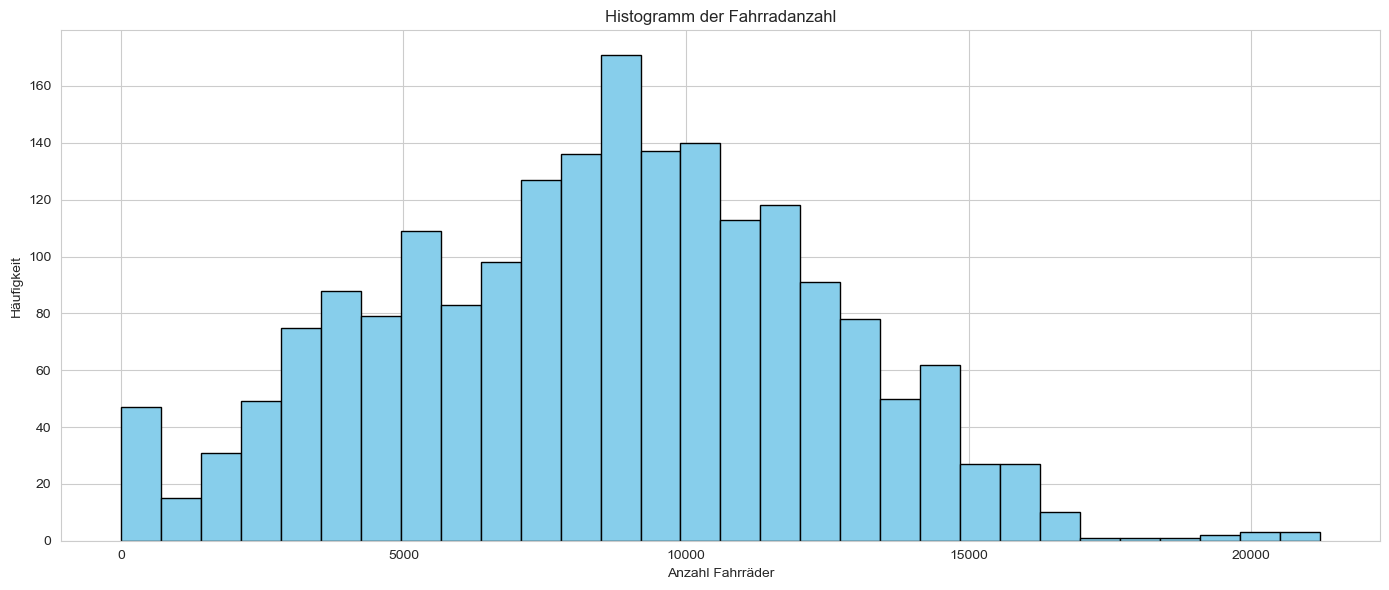

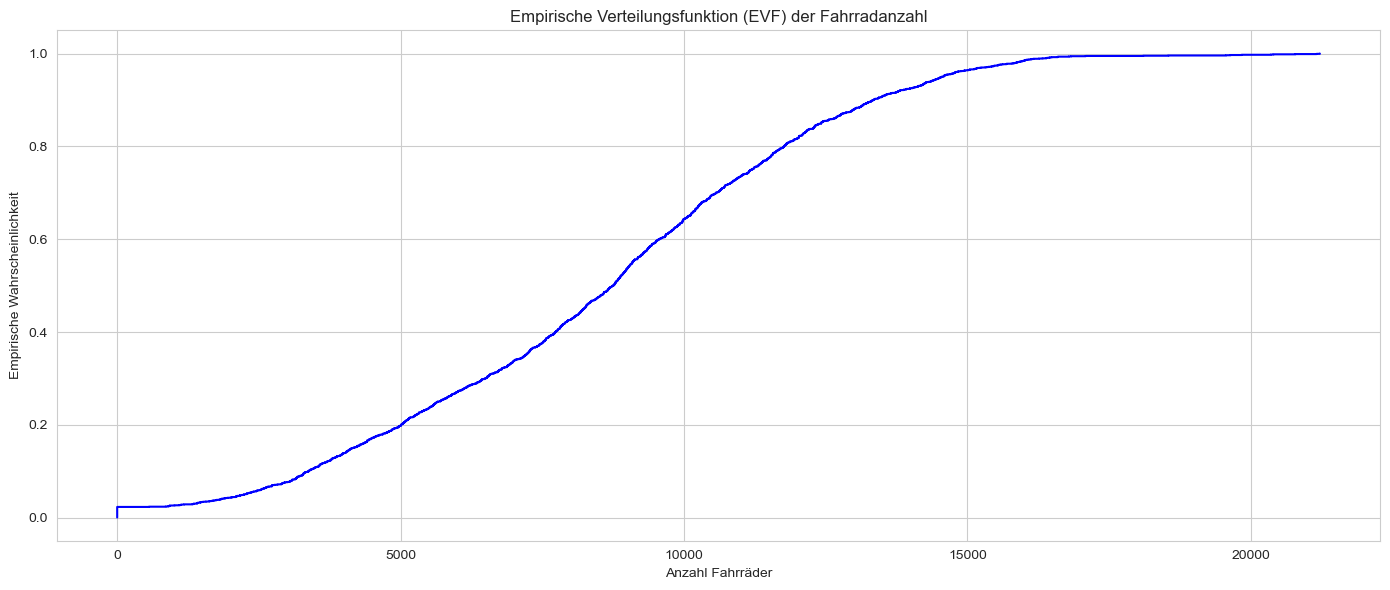

In [84]:
# Histogram
series = time_amount_tmp['total_count']

plt.figure(figsize=(14, 6))
plt.hist(series, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogramm der Fahrradanzahl')
plt.xlabel('Anzahl Fahrräder')
plt.ylabel('Häufigkeit')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Empirische Verteilungsfunktion
sorted_vals = series.sort_values().tolist()
n = len(sorted_vals)
y = [i/n for i in range(1, n+1)]

plt.figure(figsize=(14, 6))
plt.step(sorted_vals, y, where='post', color='blue')
plt.title('Empirische Verteilungsfunktion (EVF) der Fahrradanzahl')
plt.xlabel('Anzahl Fahrräder')
plt.ylabel('Empirische Wahrscheinlichkeit')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Statische Kennzahlen

Mean: 8492.993914807303
Median: 8745.5
Modalwert: 0
25%-Quantil: 5660.0
75%-Quantil: 11190.75
Standardabweichung: 3801.9841010958717
Varianz: 14455083.104985783


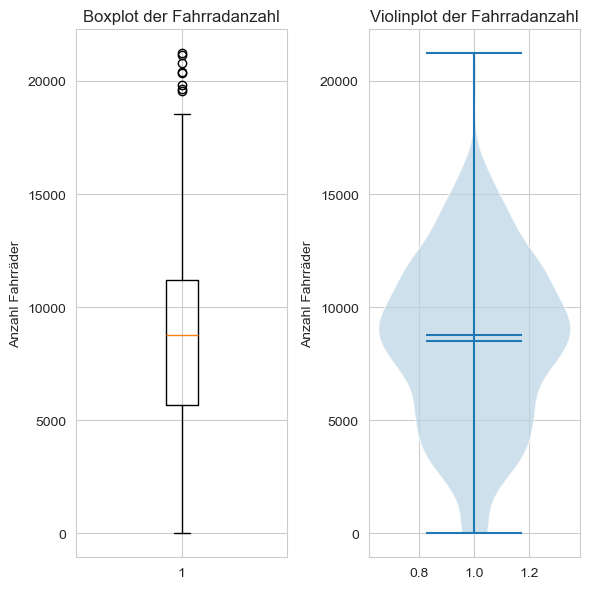

In [85]:
# Statistische Kennwerte berechnen
werte = np.array(time_amount_tmp['total_count'], dtype=float)

median = np.median(werte)
mean = np.mean(werte)
modalwert = np.bincount(werte.astype(int)).argmax()
quantile_25 = np.quantile(werte, 0.25)
quantile_75 = np.quantile(werte, 0.75)
standardabweichung = np.std(werte, ddof=1)
varianz = np.var(werte, ddof=1)

# Kennzahlen
print("Mean:", mean)
print("Median:", median)
print("Modalwert:", modalwert)
print("25%-Quantil:", quantile_25)
print("75%-Quantil:", quantile_75)
print("Standardabweichung:", standardabweichung)
print("Varianz:", varianz)

# Boxplot and Violin plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))

# Boxplot (vertical)
ax1.boxplot(werte, vert=True)
ax1.set_title('Boxplot der Fahrradanzahl')
ax1.set_ylabel('Anzahl Fahrräder')

# Violin plot (vertical) with pastel color
violin_parts = ax2.violinplot(werte, vert=True, widths=0.7, showmeans=True, showmedians=True)

# Set pastel color for violin plot
for pc in violin_parts['bodies']:
   pc.set_facecolor('#B8D4E3')  # Light blue pastel
   pc.set_alpha(0.7)

ax2.set_title('Violinplot der Fahrradanzahl')
ax2.set_ylabel('Anzahl Fahrräder')

plt.tight_layout()
plt.show()

# 3. Boxplots abhängig vom Wochentag

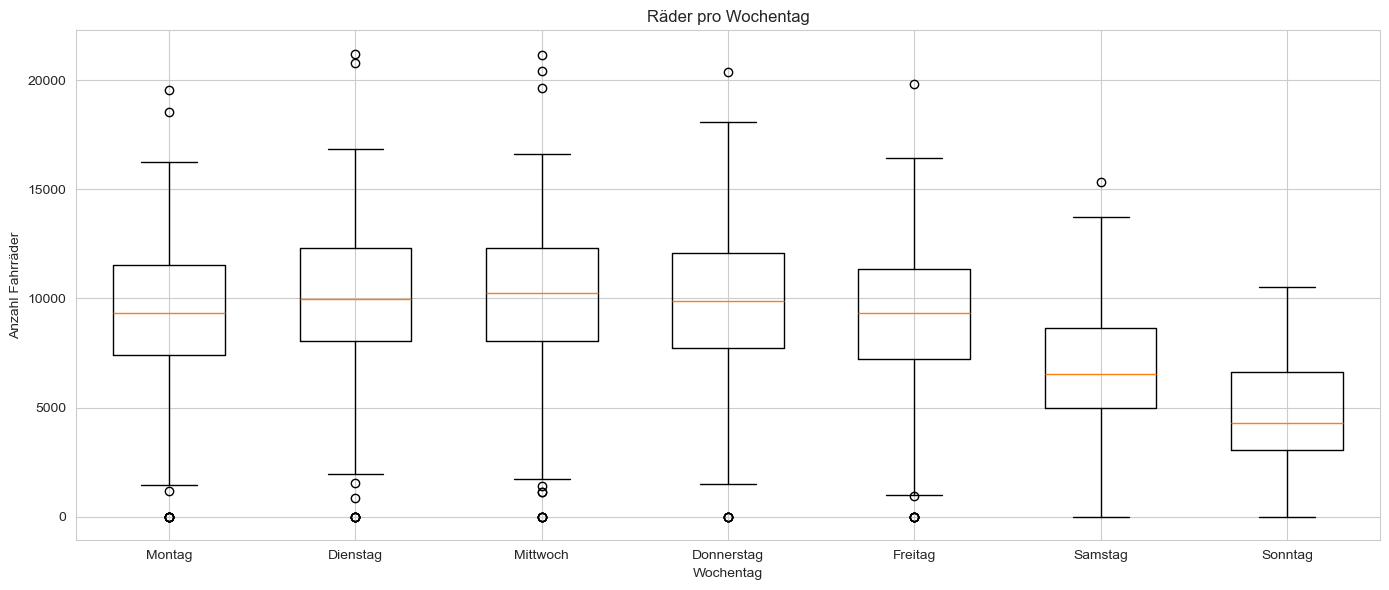

Pearson Correlation zwischen Wochentag und Anzahl Räder: -0.38439134059574126


In [86]:
df_weekday = time_amount_tmp[['dt','total_count']].copy()
df_weekday['weekday'] = df_weekday['dt'].dt.weekday
grouped = [group['total_count'].values for _, group in df_weekday.groupby('weekday')]

correlation, _ = scipy.stats.pearsonr(df_weekday['weekday'], df_weekday['total_count'])

plt.figure(figsize=(14,6))
plt.boxplot(grouped, positions=range(7), widths=0.6)
plt.xticks(range(7), ['Montag','Dienstag','Mittwoch','Donnerstag','Freitag','Samstag','Sonntag'])
plt.title('Räder pro Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Anzahl Fahrräder')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Pearson Correlation zwischen Wochentag und Anzahl Räder:", correlation)

## Multivariante Statistik

1. Scatterplot auf 2 Achsen
2. Korrelation
    - Scatterplot / Heatmap
3. Lineare Regression
4. Vorhersage

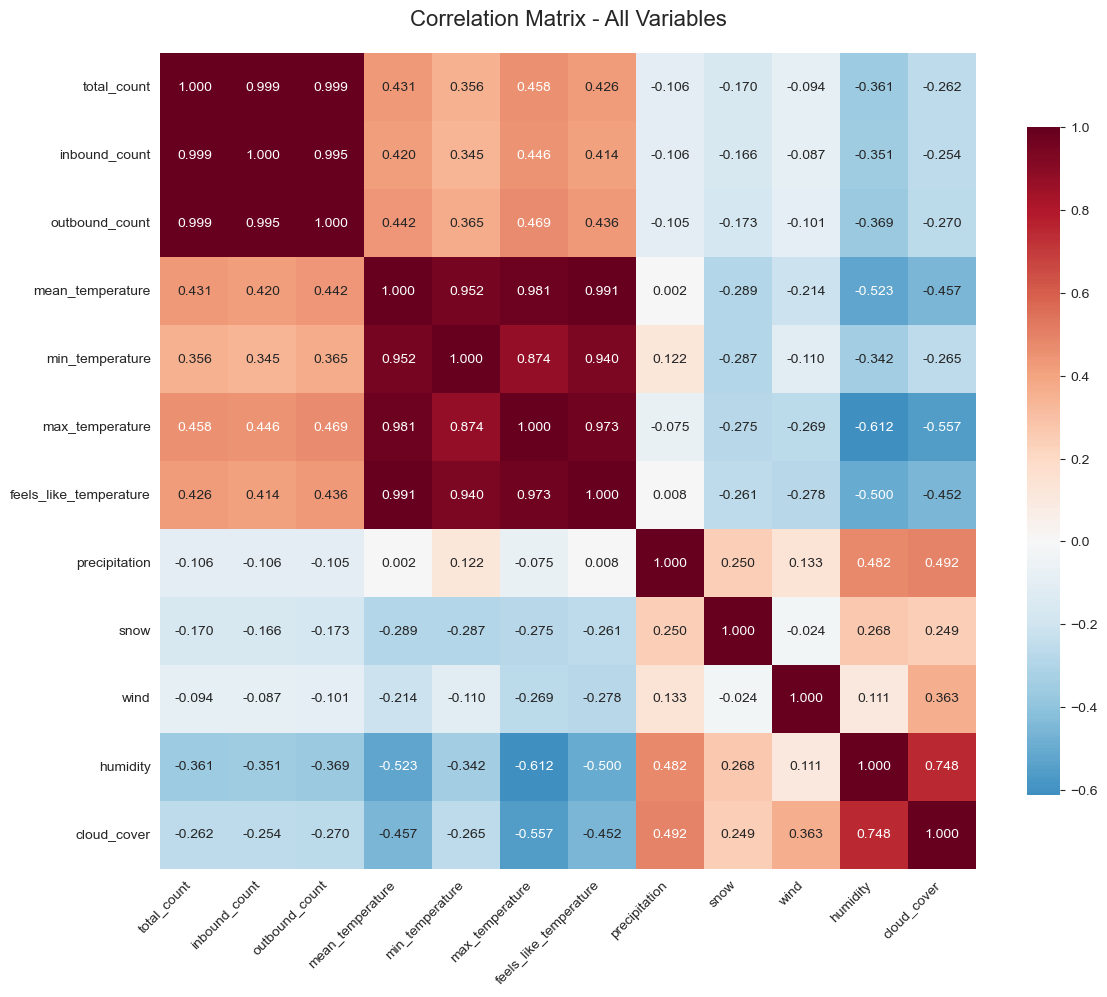

Correlation Matrix:
                        total_count  inbound_count  outbound_count  \
total_count                   1.000          0.999           0.999   
inbound_count                 0.999          1.000           0.995   
outbound_count                0.999          0.995           1.000   
mean_temperature              0.431          0.420           0.442   
min_temperature               0.356          0.345           0.365   
max_temperature               0.458          0.446           0.469   
feels_like_temperature        0.426          0.414           0.436   
precipitation                -0.106         -0.106          -0.105   
snow                         -0.170         -0.166          -0.173   
wind                         -0.094         -0.087          -0.101   
humidity                     -0.361         -0.351          -0.369   
cloud_cover                  -0.262         -0.254          -0.270   

                        mean_temperature  min_temperature  max_temper

In [87]:
# Select only numeric columns (excluding 'date')
numeric_cols = ['total_count', 'inbound_count', 'outbound_count',
                'mean_temperature', 'min_temperature', 'max_temperature',
                'feels_like_temperature', 'precipitation', 'snow', 'wind',
                'humidity', 'cloud_cover']

# Calculate correlation matrix
correlation_matrix = all_data_daily[numeric_cols].corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,           # Show correlation values
            cmap='RdBu_r',        # Red-Blue colormap (red=positive, blue=negative)
            center=0,             # Center colormap at 0
            square=True,          # Make cells square
            fmt='.3f',            # Format numbers to 3 decimal places
            cbar_kws={'shrink': 0.8})

plt.title('Correlation Matrix - All Variables', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the correlation matrix as well
print("Correlation Matrix:")
print(correlation_matrix.round(3))

# ToDo: correlate weekday
# TODO LUKAS: Zusammenhang zwischen Regen und Rädern - ggf. Regenmenge oder Regen vs. kein Regen

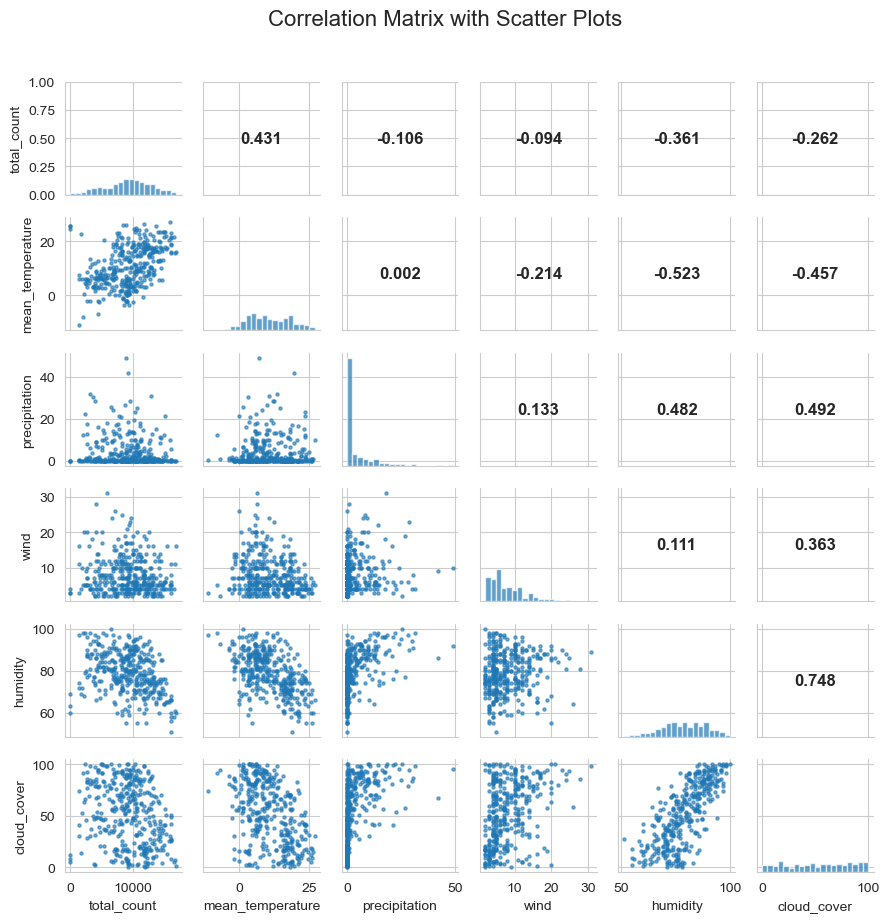

In [88]:
# Select only numeric columns (excluding 'date')
numeric_cols = ['total_count', 'mean_temperature', 'precipitation', 'wind',
               'humidity', 'cloud_cover']

# Create pairplot with scatter plots and correlation values
g = sns.PairGrid(all_data_daily[numeric_cols], height=1.5)

# Lower triangle: scatter plots
g.map_lower(plt.scatter, s=5, alpha=0.6)

# Diagonal: histograms
g.map_diag(plt.hist, bins=20, alpha=0.7)

# Upper triangle: correlation values
def corr_func(x, y, **kwargs):
   r = np.corrcoef(x, y)[0, 1]
   ax = plt.gca()
   ax.annotate(f'{r:.3f}', xy=(0.5, 0.5), xycoords='axes fraction',
               ha='center', va='center', fontsize=12, fontweight='bold')

g.map_upper(corr_func)

plt.suptitle('Correlation Matrix with Scatter Plots', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

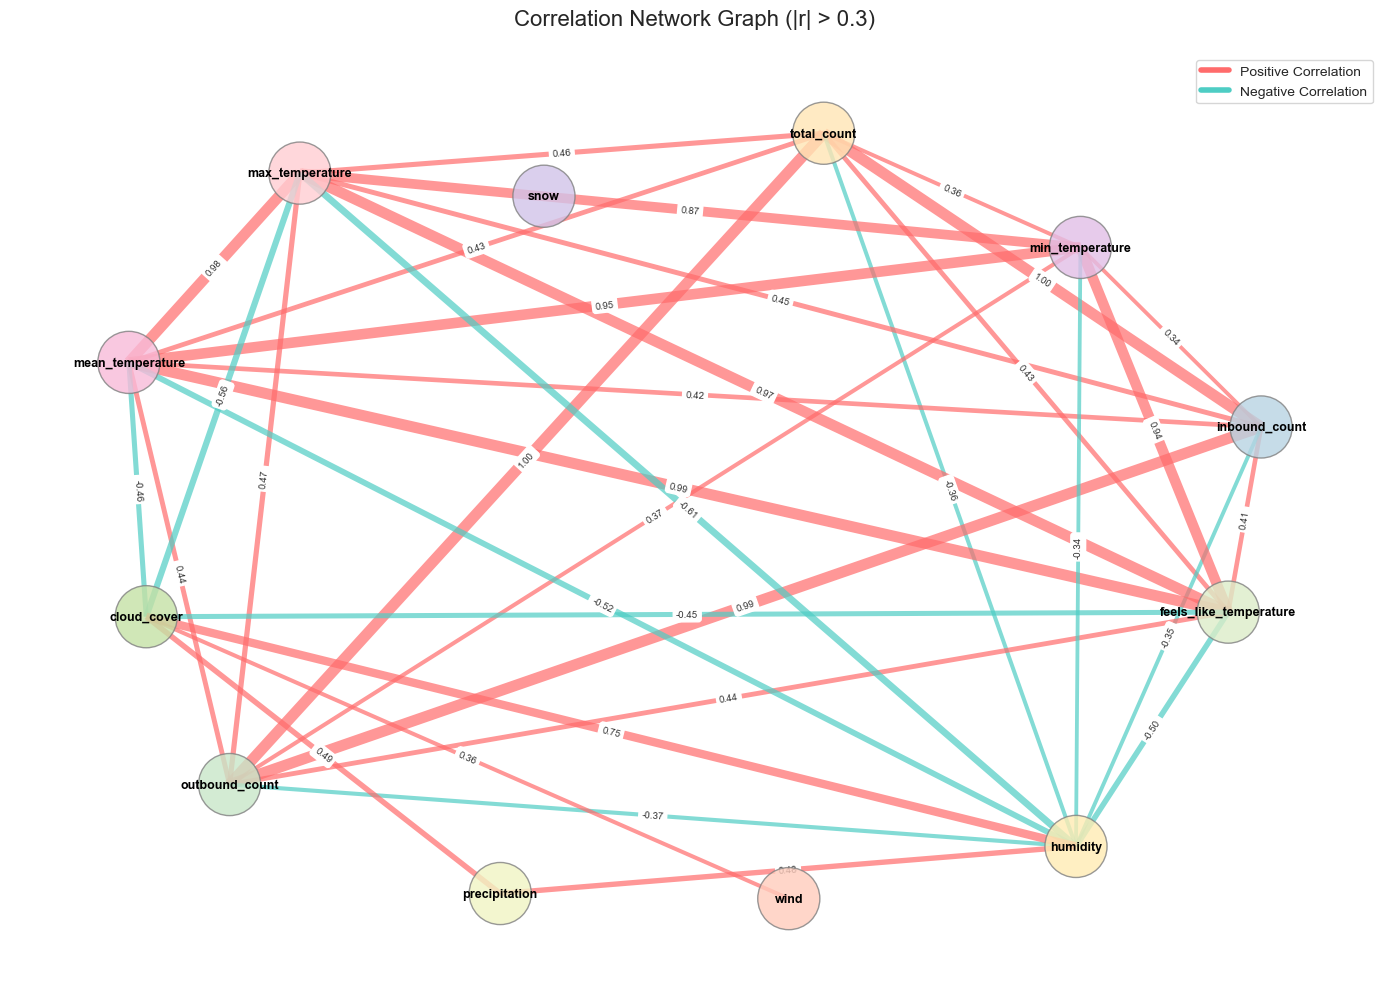

Network Statistics:
Number of nodes: 12
Number of edges: 35
Correlation threshold: 0.3

Strongest connections:
  total_count ↔ outbound_count: 0.999
  total_count ↔ inbound_count: 0.999
  inbound_count ↔ outbound_count: 0.995
  mean_temperature ↔ feels_like_temperature: 0.991
  mean_temperature ↔ max_temperature: 0.981


In [89]:
# Select only numeric columns (excluding 'date')
numeric_cols = ['total_count', 'inbound_count', 'outbound_count',
               'mean_temperature', 'min_temperature', 'max_temperature',
               'feels_like_temperature', 'precipitation', 'snow', 'wind',
               'humidity', 'cloud_cover']

# Calculate correlation matrix
correlation_matrix = all_data_daily[numeric_cols].corr()

# Create network graph from correlations
G = nx.Graph()
threshold = 0.3  # Only show correlations with absolute value > 0.3

# Add nodes
for col in correlation_matrix.columns:
   G.add_node(col)

# Add edges for correlations above threshold
for i in range(len(correlation_matrix.columns)):
   for j in range(i+1, len(correlation_matrix.columns)):
       corr = correlation_matrix.iloc[i, j]
       if abs(corr) > threshold:
           G.add_edge(correlation_matrix.columns[i],
                     correlation_matrix.columns[j],
                     weight=abs(corr),
                     correlation=corr)

# Create the plot
plt.figure(figsize=(14, 10))

# Position nodes using spring layout
pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

# Draw edges with thickness and color based on correlation
edges = G.edges()
weights = [G[u][v]['weight'] * 8 for u, v in edges]  # Scale edge thickness
edge_colors = ['#FF6B6B' if G[u][v]['correlation'] > 0 else '#4ECDC4' for u, v in edges]

nx.draw_networkx_edges(G, pos, width=weights, alpha=0.7, edge_color=edge_colors)

# Draw nodes with pastel colors
node_colors = ['#FFE5B4', '#B8D4E3', '#C8E6C9', '#F8BBD9', '#E1BEE7',
              '#FFCDD2', '#DCEDC8', '#F0F4C3', '#D1C4E9', '#FFCCBC',
              '#FFECB3', '#C5E1A5']

nx.draw_networkx_nodes(G, pos,
                     node_size=2000,
                     node_color=node_colors[:len(G.nodes())],
                     alpha=0.8,
                     edgecolors='gray',
                     linewidths=1)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

# Add edge labels with correlation values
edge_labels = {(u, v): f'{G[u][v]["correlation"]:.2f}' for u, v in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=7, alpha=0.8)

plt.title(f'Correlation Network Graph (|r| > {threshold})', fontsize=16, pad=20)
plt.axis('off')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='#FF6B6B', lw=4, label='Positive Correlation'),
                  Line2D([0], [0], color='#4ECDC4', lw=4, label='Negative Correlation')]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Print network statistics
print(f"Network Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Correlation threshold: {threshold}")
print(f"\nStrongest connections:")
edge_weights = [(u, v, G[u][v]['correlation']) for u, v in edges]
edge_weights.sort(key=lambda x: abs(x[2]), reverse=True)
for u, v, corr in edge_weights[:5]:
   print(f"  {u} ↔ {v}: {corr:.3f}")

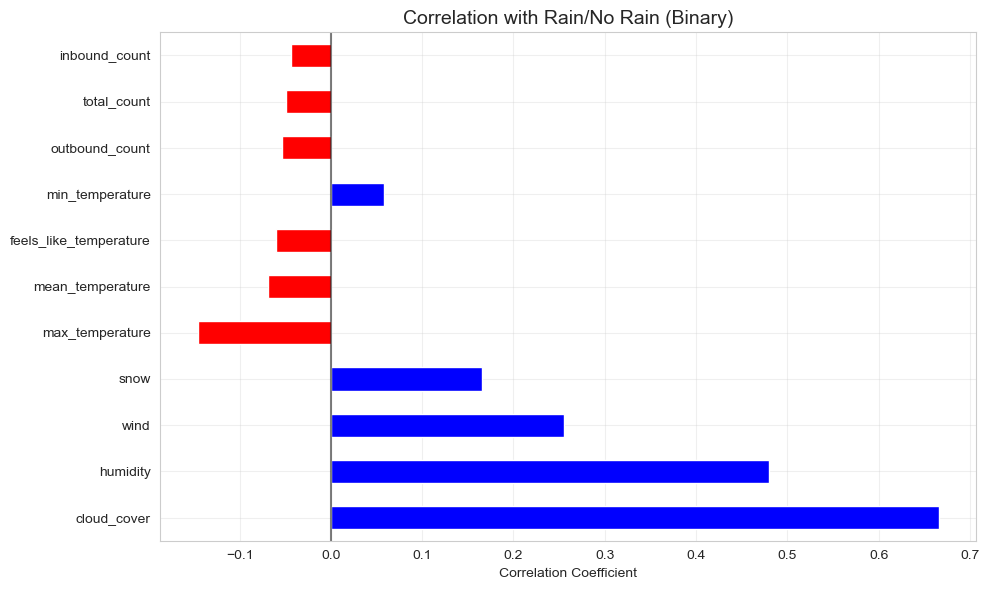


Rain statistics:
Total days: 365
Days with rain: 222 (60.8%)
Days without rain: 143 (39.2%)


In [90]:
# Create binary rain variable
all_data_daily['has_rain'] = (all_data_daily['precipitation'] > 0).astype(int)

# Create correlation matrix including the binary rain variable
numeric_cols_with_rain = ['total_count', 'inbound_count', 'outbound_count',
                         'mean_temperature', 'min_temperature', 'max_temperature',
                         'feels_like_temperature', 'snow', 'wind', 'humidity',
                         'cloud_cover', 'has_rain']

correlation_matrix_binary = all_data_daily[numeric_cols_with_rain].corr()

# Create a focused bar chart for rain correlations
plt.figure(figsize=(10, 6))
rain_correlations.plot(kind='barh', color=['red' if x < 0 else 'blue' for x in rain_correlations])
plt.title('Correlation with Rain/No Rain (Binary)', fontsize=14)
plt.xlabel('Correlation Coefficient')
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nRain statistics:")
print(f"Total days: {len(all_data_daily)}")
print(f"Days with rain: {all_data_daily['has_rain'].sum()} ({all_data_daily['has_rain'].mean()*100:.1f}%)")
print(f"Days without rain: {len(all_data_daily) - all_data_daily['has_rain'].sum()} ({(1-all_data_daily['has_rain'].mean())*100:.1f}%)")

# Zusammenhang von Temperatur und Rädern

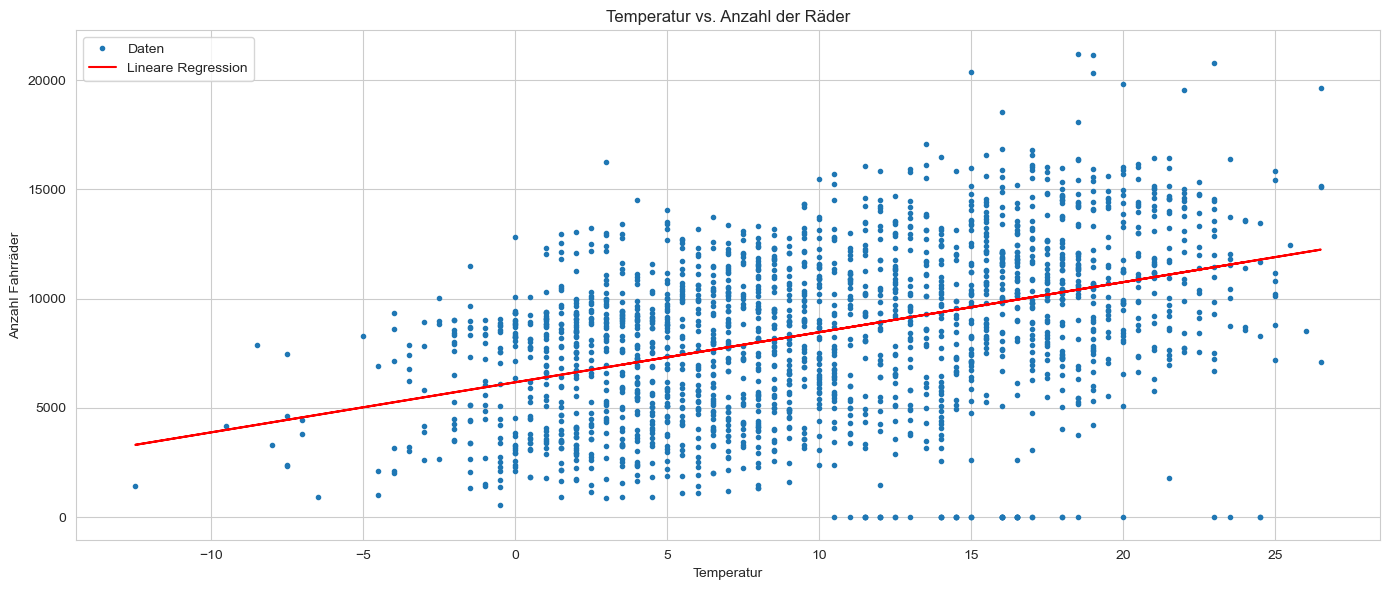

Pearson Correlation between Temperature and Raeder: 0.4232014256998625


In [91]:
# Pearson correlation
correlation, _ = scipy.stats.pearsonr(all_data_daily_constructed['mean_temperature'],
                         all_data_daily_constructed['total_count'])

# Linear regression
slope, intercept = np.polyfit(all_data_daily_constructed['mean_temperature'],
                              all_data_daily_constructed['total_count'], 1)
regression_line = np.poly1d((slope, intercept))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(all_data_daily_constructed['mean_temperature'],
         all_data_daily_constructed['total_count'],
         marker='o', linestyle='none', markersize=3, label='Daten')
plt.plot(all_data_daily_constructed['mean_temperature'],
         regression_line(all_data_daily_constructed['mean_temperature']),
         color='red', label='Lineare Regression')
plt.title('Temperatur vs. Anzahl der Räder')
plt.xlabel('Temperatur')
plt.ylabel('Anzahl Fahrräder')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Pearson Correlation between Temperature and Raeder:", correlation)

# Zusammenhang von Regen und Rädern

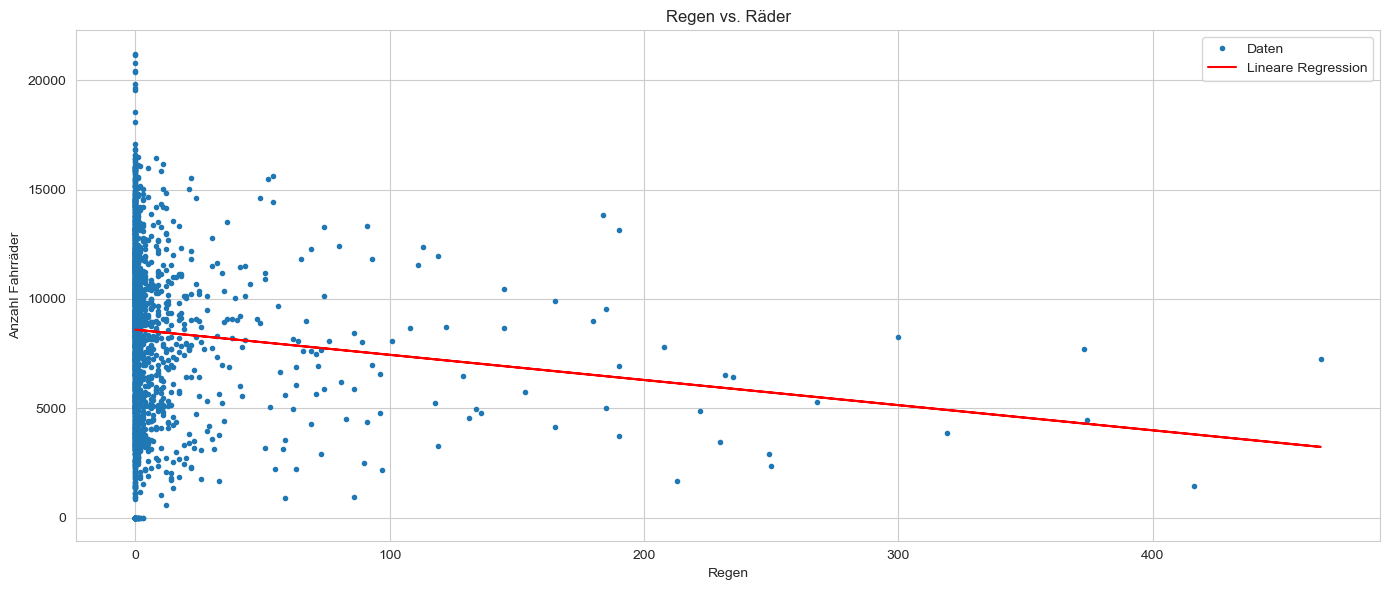

Pearson Correlation between Regen and Raeder: -0.09919255853307657


In [92]:
# Pearson correlation
correlation, _ = scipy.stats.pearsonr(all_data_daily_constructed['precipitation'],
                        all_data_daily_constructed['total_count'])

# Linear regression
slope, intercept = np.polyfit(all_data_daily_constructed['precipitation'],
                             all_data_daily_constructed['total_count'], 1)
regression_line = np.poly1d((slope, intercept))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(all_data_daily_constructed['precipitation'],
        all_data_daily_constructed['total_count'],
        marker='o', linestyle='none', markersize=3, label='Daten')
plt.plot(all_data_daily_constructed['precipitation'],
        regression_line(all_data_daily_constructed['precipitation']),
        color='red', label='Lineare Regression')
plt.title('Regen vs. Räder')
plt.xlabel('Regen')
plt.ylabel('Anzahl Fahrräder')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Pearson Correlation between Regen and Raeder:", correlation)

Total days: 1972
Rainy days: 742 (37.6%)


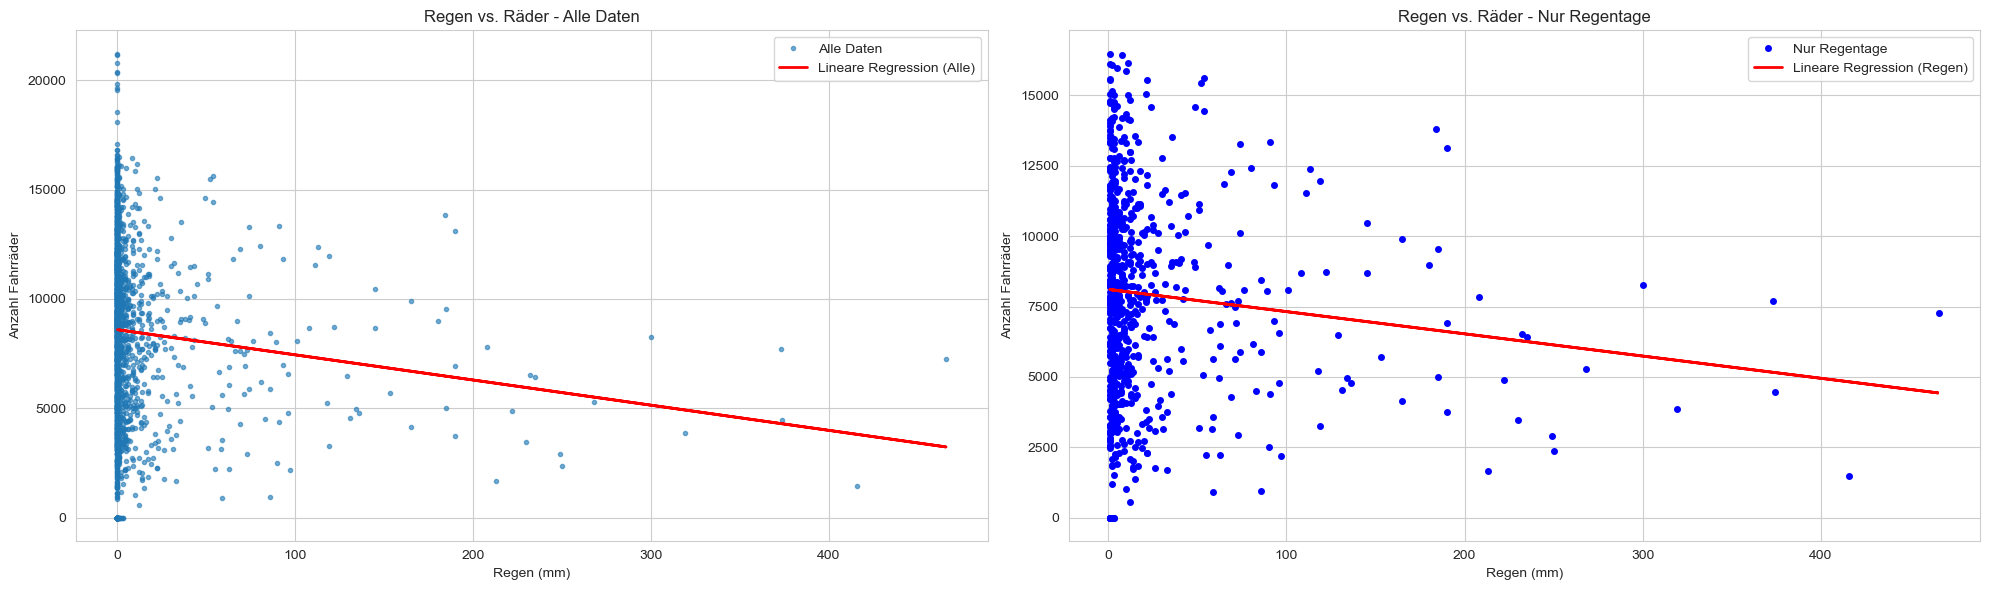

Pearson Correlation (alle Daten): -0.0992
Pearson Correlation (nur Regentage): -0.1128
Slope (alle Daten): -11.51
Slope (nur Regentage): -7.90


In [93]:
# Filter to only days with precipitation > 0
rainy_days_mask = all_data_daily_constructed['precipitation'] > 0
rainy_data = all_data_daily_constructed[rainy_days_mask]

print(f"Total days: {len(all_data_daily_constructed)}")
print(f"Rainy days: {len(rainy_data)} ({len(rainy_data)/len(all_data_daily_constructed)*100:.1f}%)")

# Pearson correlation for all data
correlation_all, _ = scipy.stats.pearsonr(all_data_daily_constructed['precipitation'],
                            all_data_daily_constructed['total_count'])

# Pearson correlation for rainy days only
correlation_rainy, _ = scipy.stats.pearsonr(rainy_data['precipitation'],
                              rainy_data['total_count'])

# Linear regression for all data
slope_all, intercept_all = np.polyfit(all_data_daily_constructed['precipitation'],
                                    all_data_daily_constructed['total_count'], 1)
regression_line_all = np.poly1d((slope_all, intercept_all))

# Linear regression for rainy days only
slope_rainy, intercept_rainy = np.polyfit(rainy_data['precipitation'],
                                        rainy_data['total_count'], 1)
regression_line_rainy = np.poly1d((slope_rainy, intercept_rainy))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: All data
ax1.plot(all_data_daily_constructed['precipitation'],
        all_data_daily_constructed['total_count'],
        marker='o', linestyle='none', markersize=3, label='Alle Daten', alpha=0.6)
ax1.plot(all_data_daily_constructed['precipitation'],
        regression_line_all(all_data_daily_constructed['precipitation']),
        color='red', label='Lineare Regression (Alle)', linewidth=2)
ax1.set_title('Regen vs. Räder - Alle Daten')
ax1.set_xlabel('Regen (mm)')
ax1.set_ylabel('Anzahl Fahrräder')
ax1.grid(True)
ax1.legend()

# Plot 2: Rainy days only
ax2.plot(rainy_data['precipitation'],
        rainy_data['total_count'],
        marker='o', linestyle='none', markersize=4, label='Nur Regentage', color='blue')
ax2.plot(rainy_data['precipitation'],
        regression_line_rainy(rainy_data['precipitation']),
        color='red', label='Lineare Regression (Regen)', linewidth=2)
ax2.set_title('Regen vs. Räder - Nur Regentage')
ax2.set_xlabel('Regen (mm)')
ax2.set_ylabel('Anzahl Fahrräder')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Pearson Correlation (alle Daten): {correlation_all:.4f}")
print(f"Pearson Correlation (nur Regentage): {correlation_rainy:.4f}")
print(f"Slope (alle Daten): {slope_all:.2f}")
print(f"Slope (nur Regentage): {slope_rainy:.2f}")

# Zusammenhang von Temperatur und Rädern

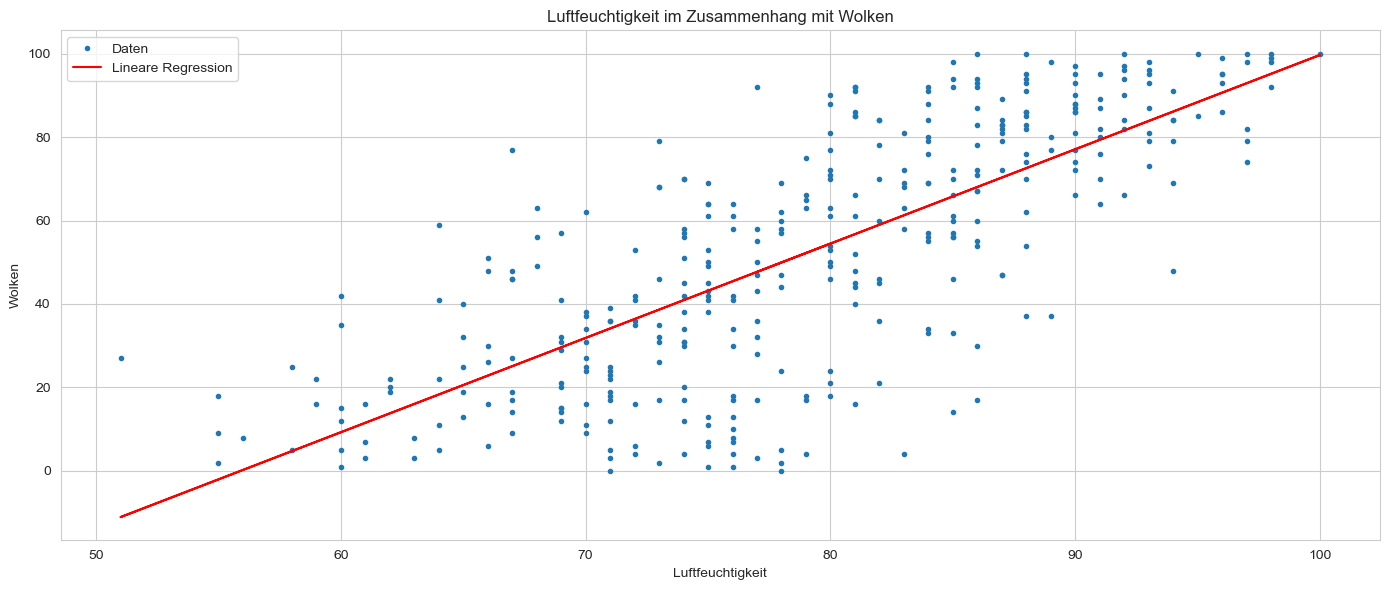

Pearson Correlation between Humidity and Cloud Cover: 0.7481752147486929


In [94]:
# Pearson correlation
correlation, _ = scipy.stats.pearsonr(all_data_daily['humidity'],
                         all_data_daily['cloud_cover'])

# Linear regression
slope, intercept = np.polyfit(all_data_daily['humidity'],
                              all_data_daily['cloud_cover'], 1)
regression_line = np.poly1d((slope, intercept))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(all_data_daily['humidity'],
         all_data_daily['cloud_cover'],
         marker='o', linestyle='none', markersize=3, label='Daten')
plt.plot(all_data_daily['humidity'],
         regression_line(all_data_daily['humidity']),
         color='red', label='Lineare Regression')
plt.title('Luftfeuchtigkeit im Zusammenhang mit Wolken')
plt.xlabel('Luftfeuchtigkeit')
plt.ylabel('Wolken')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Pearson Correlation between Humidity and Cloud Cover:", correlation)

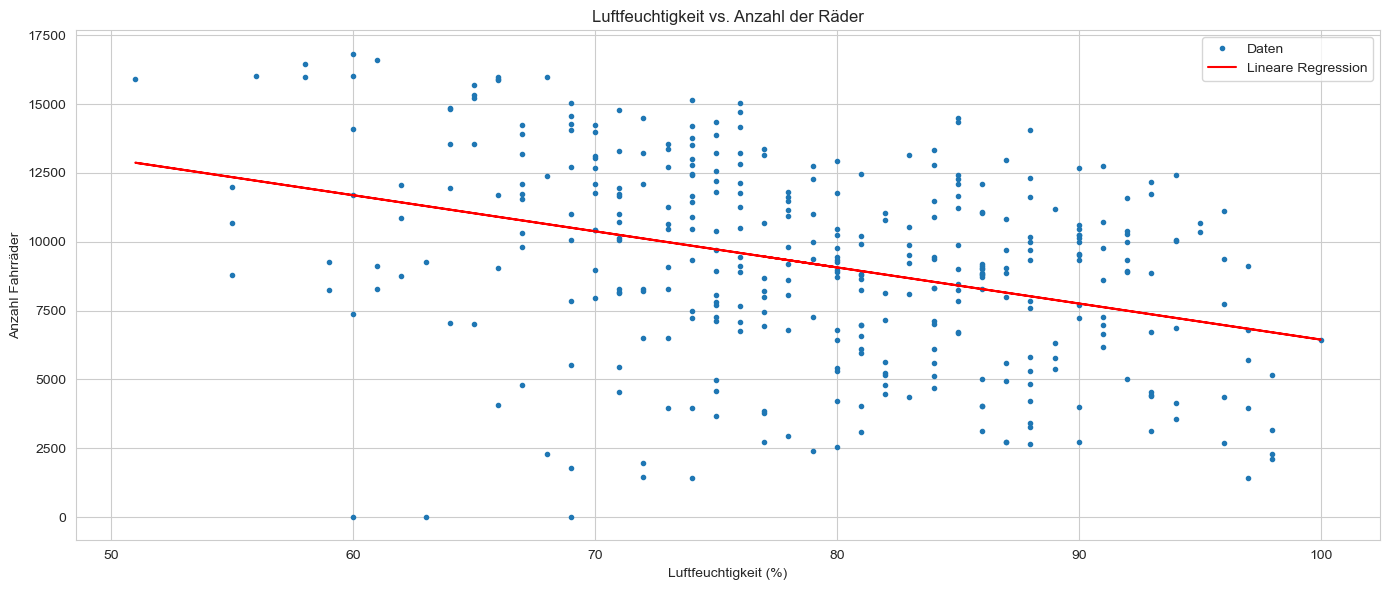

Pearson Correlation between Humidity and Total Count: -0.3605070031822394


In [95]:
# Pearson correlation
correlation, _ = scipy.stats.pearsonr(all_data_daily['humidity'],
                                    all_data_daily['total_count'])

# Linear regression
slope, intercept = np.polyfit(all_data_daily['humidity'],
                             all_data_daily['total_count'], 1)
regression_line = np.poly1d((slope, intercept))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(all_data_daily['humidity'],
        all_data_daily['total_count'],
        marker='o', linestyle='none', markersize=3, label='Daten')
plt.plot(all_data_daily['humidity'],
        regression_line(all_data_daily['humidity']),
        color='red', label='Lineare Regression')
plt.title('Luftfeuchtigkeit vs. Anzahl der Räder')
plt.xlabel('Luftfeuchtigkeit (%)')
plt.ylabel('Anzahl Fahrräder')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Pearson Correlation between Humidity and Total Count:", correlation)